In [1]:
# DRAW MATPLOTLIB IN NOTEBOOK #

%matplotlib inline
# %matplotlib notebook

In [9]:
# LIBRARIES #

import numpy as np
import pydicom as dcm
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage

import SimpleITK as sitk

In [13]:
# INPUT PARAMETERS #
#m_filename = 'G:/Commun/PHYSICIENS/CONTROLE QUALITE/06 CK M6/CQ mensuel/2019/2019 06 06/Gafchromic/lumineux-irradie/'
m_filename = 'colli5_72dpi.tif'

m_coefA = 1774.1   #x3
m_coefB = -3907.8  #x2
m_coefC = 3276.7   #x
m_coefD = -935.12

m_dosemax = 350.0 #cGy

In [14]:
# READS THE IMAGE AND CONVERTS IT TO DOSE #

def readAndConvertImgToDose(filename, coefs, dosemax):
    # reads the image using simpleITK:
    img = sitk.ReadImage(filename)
    sizex = img.GetWidth()
    sizey = img.GetHeight()
    imgOrigin = img.GetOrigin()
    imgSpacing = img.GetSpacing()
    array = sitk.GetArrayFromImage(img)
    
    # replaces every 65535 value in array with 65534 to avoid division by zero:
    array[array==65535]=65534
    
    # converts in optical density
    dor = -np.log10(array[:,:,0]/65535.0)
    dob = -np.log10(array[:,:,2]/65535.0)
    
    # red channel over blue channel:
    rsb = dor/dob
#    rsb[rsb>1.3] = 1.3

    # converting in dose:
    dose = coefs[0]*rsb**3 + coefs[1]*rsb**2 + coefs[2]*rsb + coefs[3]
    dose[dose>dosemax] = dosemax
    dose[dose<0] = 0
    
    return dose, sizex, sizey, imgOrigin, imgSpacing

Center of mass: 41 44


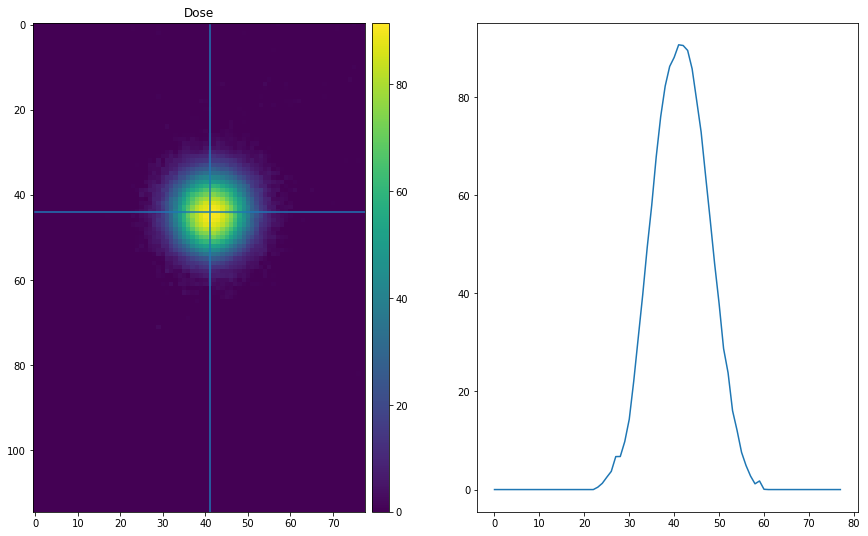

In [16]:
# PLOTS THE DOSE IMAGE #

coefs = [m_coefA, m_coefB, m_coefC, m_coefD]

doseimg, sizex, sizey, imgOrigin, imgSpacing = readAndConvertImgToDose(m_filename, coefs, m_dosemax)

plt.rcParams['figure.figsize'] = (15,9)
fig = plt.figure()
gs = gridspec.GridSpec(1,2)

ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(doseimg)#, cmap="Greys", vmin = 0, vmax = 100)
ax1.set_title('Dose')
#ax1.axes.get_xaxis().set_visible(False)
#ax1.axes.get_yaxis().set_visible(False)
ax1.axes.autoscale(False)

com = ndimage.measurements.center_of_mass(doseimg[10:sizex-10,10:sizey-10])
comx = int(com[1])+10
comy = int(com[0])+10
print("Center of mass:", comx, comy)

linex = [0,sizex]
liney = [comy,comy]
line1 = plt.Line2D(linex, liney)
ax1.add_line(line1)
linex = [comx,comx]
liney = [0,sizey]
line2 = plt.Line2D(linex, liney)
ax1.add_line(line2)

ax2 = fig.add_subplot(gs[1])
im2 = ax2.plot(doseimg[comy,:])

try:
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im1, cax=cax1)
except:
    print('Error displaying images side bars')